In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [1]:
groq_api_key = os.getenv("GROQ_API_KEY")

NameError: name 'os' is not defined

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-8b-instant", groq_api_key=groq_api_key)

In [4]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper


In [5]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [6]:
arxiv.invoke("deep learning")

'Published: 2018-05-22\nTitle: Opening the black box of deep learning\nAuthors: Dian Lei, Xiaoxiao Chen, Jianfei Zhao\nSummary: The great success of deep learning shows that its technology contains\nprofound truth, and understanding its internal mechanism not only has important\nimplications for the development of its technology and effective application in\nvarious fields, but also provides meaningful insights into the understanding of\nhuman brain mechanism. At present, most of the theoretical researc'

In [7]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [8]:
wiki.invoke("AI")

e:\Agentic AI\langenv\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file e:\Agentic AI\langenv\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


'Page: Artificial intelligence\nSummary: Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goal'

In [9]:
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()



C:\Users\Bharat\AppData\Local\Temp\ipykernel_29856\4175261396.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [10]:
tavily.invoke("provide latest AI news")

[{'title': 'The latest AI news we announced in October - Google Blog',
  'url': 'https://blog.google/technology/ai/google-ai-updates-october-2025/',
  'content': '"The Latest AI News We Announced in October" highlights Google\'s recent AI advancements.\n Google\'s AI breakthroughs include a quantum algorithm faster than supercomputers.\n An AI model called Cell2Sentence-Scale may offer a new cancer therapy pathway.\n Gemini Enterprise is now the "front door" for Google AI in the workplace.\n New AI security features protect against scams, plus Google Home gets AI upgrades.\n\n## Shakespeare-ish [...] # The latest AI news we announced in October\n\nNov 04, 2025\n\nHere’s a recap of some of our biggest AI updates from October, including Gemini Enterprise, an AI model to accelerate cancer research and a big quantum computing breakthrough.\n\nSuperG\n\n## General summary [...] a text card reading "AI for a more secure digital world"\n\nWe rolled out new security features to shield you from

In [11]:
tools = [arxiv, wiki, tavily]
llm_with_tools = llm.bind_tools(tools)

In [12]:
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content="what is the capital of india")]).tool_calls

[{'name': 'wikipedia',
  'args': {'query': 'Capital of India'},
  'id': '22q42vn3j',
  'type': 'tool_call'}]

In [13]:
llm_with_tools.invoke([HumanMessage(content="indian Current affairs")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'Indian current affairs'},
  'id': 'fs7bf93kr',
  'type': 'tool_call'}]

In [14]:
llm_with_tools.invoke([HumanMessage(content="latest ML reasearch paper")]).tool_calls

[{'name': 'arxiv',
  'args': {'query': 'latest machine learning research paper'},
  'id': 'fn2g0fvjs',
  'type': 'tool_call'}]

In [29]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, HumanMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):  
    messages:Annotated[list[AnyMessage],add_messages]



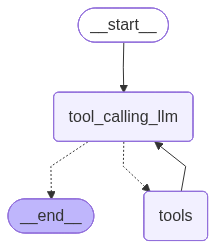

In [19]:
#chatbot with langchain
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict, Annotated, Sequence
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)   
builder.add_node("tools", ToolNode(tools=tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
    {"tools": "tools", "__end__": END}  # optional explicit mapping
)
builder.add_edge("tools", "tool_calling_llm")  # ✅ loop back

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
messages = graph.invoke({"messages":HumanMessage(content="what is ML")})
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

what is ML
================================== Ai Message ==================================
Tool Calls:
  wikipedia (s234p1b2z)
 Call ID: s234p1b2z
  Args:
    query: Machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
================================== Ai Message ==================================
Tool Calls:
  arxiv (sm70bs7q5)
 Call ID: sm70bs7q5
  

In [33]:
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]='true'
os.environ["LANGCHAIN_PROJECT"]='ReAct-agent'


In [38]:
def multiply(a: int, b: int) -> int:
    return a*b
def add(a: int, b: int) -> int:
    return a+b
def devide(a:int, b: int) -> int:
    return a/b


tools = [arxiv, wiki, tavily,add, multiply, devide]

llm = ChatGroq(model="llama-3.1-8b-instant")
llm_with_tools=llm.bind_tools(tools)

In [42]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.prebuilt import ToolNode, tools_condition
llm_with_tools.invoke([HumanMessage(content=f"what is the AI news")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'me7j4zdy1', 'function': {'arguments': '{"query":"AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 683, 'total_tokens': 702, 'completion_time': 0.022184049, 'prompt_time': 0.037573413, 'queue_time': 0.049797461, 'total_time': 0.059757462}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--242c0ceb-6f59-4d7c-8f25-c935da1325cb-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'AI news'}, 'id': 'me7j4zdy1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 683, 'output_tokens': 19, 'total_tokens': 702})

In [43]:
def agent(state:State):
    return {"messages":[agent.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("agent",agent)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,agent)
builder.add_conditional_edges(
    "agent",
    tools_condition,
    )
builder.add_edge("agent")#

graph = builder.compile()


ValueError: Function must have a docstring if description not provided.